<a href="https://colab.research.google.com/github/eridanirojas/563-rojas/blob/main/3DMCSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Monte Carlo Sampling Project for MSE 563
# Summary: This project aims to simulate a Markovian-Chain Metroplis Monte Carlo simulation in 3 dimensions, using the Lennard Jones potential
# to calculate pairwise potentials. The goal is to see the overall performance of this model, including equilibration times, accuracy, runtimes,
# and output ensemble.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import math
import time
import copy

In [ ]:
# Initialize system
class System():
  def __init__(self,N,L,T):
    self.V = L**3
    self.L = L
    self.N = N
    self.T = T
    self.particles = self.fill_system(N, L, r_min=1.0)  # Ensure spacing

  def fill_system(self, N, L, r_min=1.0):
    # Reduce chances of two particles overlapping, so rare this is enough to cover it
    particles = []
    while len(particles) < N:
      new_particle = L * np.random.rand(3)
      too_close = any(np.linalg.norm(new_particle - p) < r_min for p in particles)
      if not too_close:
        particles.append(new_particle)  # Add if spacing is fine
    return np.array(particles)

  def compute_energy(self, ideal_gas = False):
    # To calculate energy of a system
    energy_sum = 0.0
    pairs = 0
    virial_sum = 0.0
    if ideal_gas is True: # If system behaves as an ideal gas, there can be no interactions
      pressure = (self.N * self.T / self.V)
      return energy_sum, pairs, pressure # energy, pairs, and pressure
    for i in range(self.N - 1):
        for j in range(i + 1, self.N):
            e, v = self.LJ_potential(self.particles[i], self.particles[j])
            energy_sum += e
            virial_sum += v
            if not np.isclose(e, 0.0):
                pairs += 1
    pressure = (self.N * self.T / self.V) + (virial_sum / (3 * self.V))
    return energy_sum, pairs, pressure # energy, pairs, and pressure

  def distance(self, particle1, particle2):
    # Distance between two particles considering PBCs

    # Displacement vector
    delta = particle2 - particle1

    # Shifting to be between -L/2 and L/2
    delta -= np.round(delta / self.L) * self.L

    # Distance
    r = np.linalg.norm(delta)

    return r

  def LJ_potential(self, particle1, particle2, epsilon=1.0, sigma=1.0, r_cut = 2.5):
    # LJ potential and virial theorem

    # Getting distance with PBCs in mind
    r = self.distance(particle1, particle2)
    if r > r_cut:
      return 0.0, 0.0

    # Handling overlaps
    if np.isclose(r, 0.0):
      print("too close")
      return np.inf, np.inf

    # Compute LJ potential
    sr6 = (sigma / r) ** 6
    sr12 = sr6 * sr6

    # Lennard-Jones Force
    F_LJ = 24.0 * epsilon * (2 * sr12 - sr6) / r

    # Virial summation contribution: r * F
    v = r * F_LJ

    return 4.0 * epsilon * (sr12 - sr6), v

  def plot(self, particles, L, title = "Current configuration"):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(particles[:,0], particles[:,1], particles[:,2], c='blue', marker='o')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_zlim(0, L)
    plt.title(title)
    plt.show()

In [ ]:
# Monte Carlo Simulation, with Markov-Chain implementation and with delta as a step size, from Frenkel and Smit

def simulation(system, steps, T=1.0, delta = 1, ideal_gas = False):
    # Making a copy to not disturb initial configuration
    sim_system = copy.deepcopy(system)

    # Calculate initial energy and initial virial sum
    energy, pairs, pressure = sim_system.compute_energy(ideal_gas)

    # Pressure list
    pressures = [pressure]
    # Energy list
    energies = [energy]

    # Configuration list
    configs = [copy.deepcopy(sim_system.particles)]

    # Initialize accepted and rejected tally
    accepted = 0
    rejected = 0

    for step in range(steps):
        # Pick a random particle
        i = np.random.randint(sim_system.N)

        # Store initial position
        initial_pos = sim_system.particles[i].copy()

        # Compute initial energy of system
        E_initial, _, P_initial = sim_system.compute_energy(ideal_gas)

        # Propose a move using step size factor delta
        displacement = (np.random.rand(3) - 0.5) * delta
        sim_system.particles[i] += displacement

        # PBCs, if applicable to displacement
        sim_system.particles[i] %= sim_system.L

        # Compute final energy and pressure
        E_final, _, P_final = sim_system.compute_energy(ideal_gas)
        dE = E_final - E_initial

        # Metropolis criteria
        if np.random.rand() < np.exp(-dE/T):
            accepted += 1
            energy = E_final # Accept the move
            pressure = P_final
        else:
            sim_system.particles[i] = initial_pos # Reject the move
            rejected += 1
            energy = E_initial
            pressure = P_initial

        energies.append(energy) # Energy history
        configs.append(copy.deepcopy(sim_system.particles)) # Configuration history
        pressures.append(pressure) # Pressure history

    return energies, accepted, rejected, configs, pressures

In [ ]:
N = 15
L = 7
T = 0.05
V = L**3

In [ ]:
system = System(N,L,T)
system.compute_energy()

(-4.128052286427433, 25, -0.016145356271833028)

In [ ]:
energies, accepted, rejected, configs, pressures = simulation(system, 1000, T = T, ideal_gas = False)

In [ ]:
acceptance_rate = accepted/(accepted + rejected)

In [ ]:
print(acceptance_rate)

0.117


In [ ]:
energies[0]

-4.128052286427433

In [ ]:
energies[-1]

-17.853129345598568

Text(0.5, 1.0, 'Compressibility factor over time')

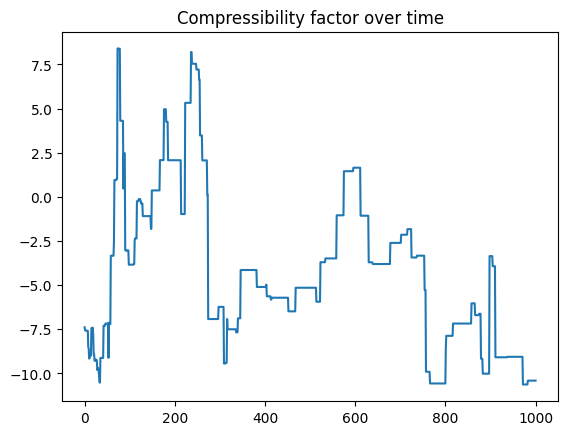

In [ ]:
Z_values = [(P * V) / (N * T) for P in pressures] # Relationship between pressure, volume, and temperature of system, equation of state?
plt.plot(Z_values)
plt.title("Compressibility factor over time")

Text(0.5, 1.0, 'Energy over time')

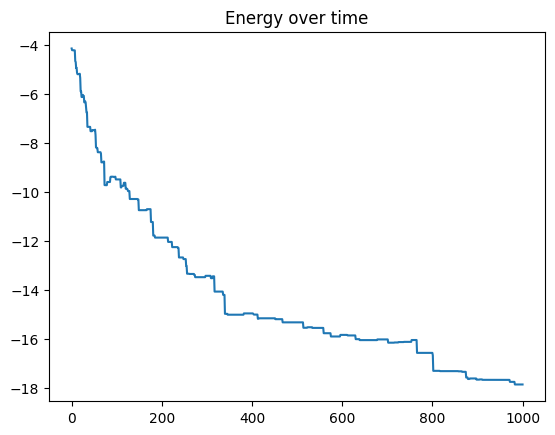

In [ ]:
plt.plot(energies)
plt.title("Energy over time")

Text(0.5, 1.0, 'Pressure over time')

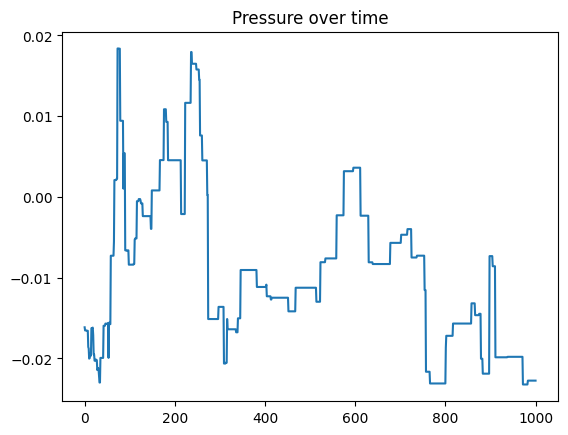

In [ ]:
plt.plot(pressures)
plt.title("Pressure over time")

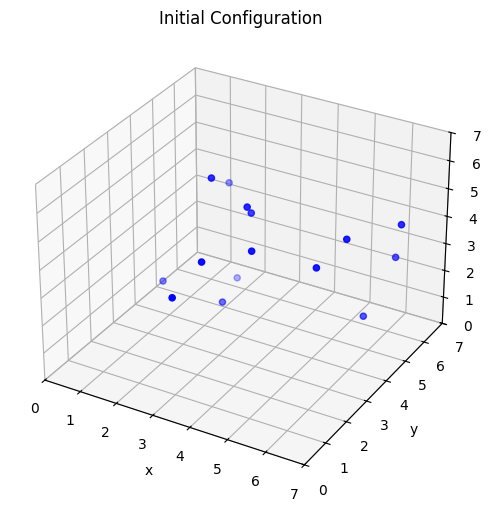

In [ ]:
system.plot(configs[0], 7, title = "Initial Configuration")

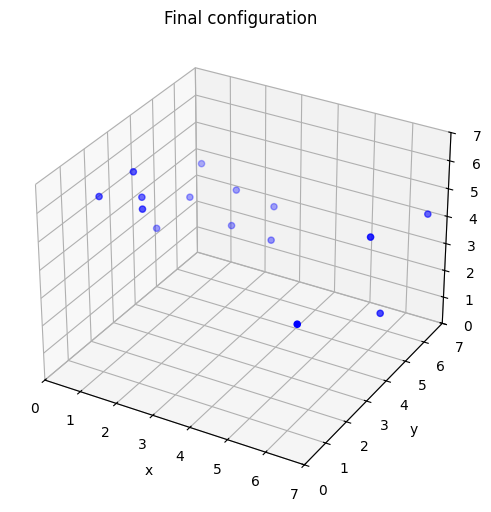

In [ ]:
system.plot(configs[-1], 7, title = "Final configuration")